# Building a Simple Auto-Encoder - Lab

## Introduction
In this lab, we will try to build a simple autoencoder using Keras. We will work with the fashion-MNIST dataset to work out a problem of image compression and reconstruction. With a simple AE, the results may not be highly impressive, but the key takeaway from this lab is to see how the encoding/decoding functions are implemented neural nets and are differentiable with respect to the distance function. The differentiable part enables optimizing the parameters of the encoding/decoding functions to minimize the reconstruction loss.

Note: Refer to [Keras dcumentation](https://keras.io/) for details on methods used in this lab. 

## Objectives
- Build a simple autoencoder in Keras
- Create the encoder and decoder functions as fully connected layers of a feed forward styled neural network. 
- Train an autoencoder with selected loss function and optimizer.

First let's import all the necessary libraries required for this experiment.

In [13]:
# Install tensorflow and keras if you haven't done so already
# !pip install tensorflow
# !pip install keras

# Import necessary libraries
import numpy as np
import keras
from keras.datasets import fashion_mnist
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape
from keras import regularizers

from IPython.display import Image
import matplotlib.pyplot as plt

### The Fashion-MNIST dataset

We have already seen the popular MNIST dataset in our previous lessons. Let's load the very similar ["fashion-mnist" dataset](https://github.com/zalandoresearch/fashion-mnist). 

*"Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. We intend Fashion-MNIST to serve as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits."* 

This dataset comes packaged with keras and can be loaded using `fashion_mnist.load_data()`. More details on keras datasets can be seen on [keras documentation](https://keras.io/datasets/). Below is a quick sample of images that you may find in this dataset.

<img src="dataset.png" width=700>

Perform following tasks:
- Load the Fashion-mnist feature set into test and training datasets (ignore labels/targets for now)
- Normalize the values of train and test datasets between 0 and 1
- Check the shape of both datasets created above. 

In [51]:
# Load the training and test data sets (ignoring labels)
(x_train, _), (x_test, _) = fashion_mnist.load_data()

# Normalize the train and test data to a range between 0 and 1.
max_value = float(x_train.max())
x_train = x_train.astype('float32') / max_value
x_test = x_test.astype('float32') / max_value
x_train.shape, x_test.shape

((60000, 28, 28), (10000, 28, 28))

Above we see that we have 3D arrays of train and test datasets containg 60K and 10K images of size 28x28 pixels. To work with the images as vectors, let’s reshape the 3D arrays as 2D matrices. 

- Reshape the 28 x 28 images into vectors of length 784 for both train and test set
- Print the shape of new datasets

In [35]:
# Reshape the training data to create 1D vectors
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

(x_train.shape, x_test.shape)

((60000, 784), (10000, 784))

## Build a Simple AutoEncoder

With our pre-processed data, we can start building a simple autoencoder with its The encoder and decoder functions are each __fully-connected__ neural layers. The encoder function will use a __ReLU__ (Rectified Linear Unit) activation function, while the decoder function uses a __sigmoid__ activation function.

[Here is a good reference on non-linear functions](https://towardsdatascience.com/activation-functions-and-its-types-which-is-better-a9a5310cc8f). 

> The encoder layer encodes the input image as a compressed, latent representation with reduced dimensionality. The decoder layer decodes the encoded image back to the original dimension. 

Here we will create the compressed representation with 32 dimensions with a __compression factor__  784 / 32 = 24.5

Let's build our Model . Perform following tasks.

- Define encoding dimensions (32) and calculate/print the compression factor
- Create a `Sequential()` autoencoder model in Keras

- Create a fully connected  __encoder layer__  to reduce the dimension from the original 784-dimensional vector to encoded 32-dimensional vector. Use the `relu` activation function

- Create a fully connected __decoder layer__ to restore the dimension from the encoded 32-dimensional representation back to the original 784-dimensional vector.Use `sigmoid` activation function

- Print he model summary 

In [50]:
# IDentify input and encoding dimensions
input_dim = x_train.shape[1] # input dimension = 784
encoding_dim = 32

# Calculate the compression factor
compression_factor = float(input_dim) / encoding_dim
print("Compression factor: %s" % compression_factor)

# Build the autoencoder model 
autoencoder = Sequential()
# Encoder Layer
autoencoder.add(Dense(encoding_dim, input_shape=(input_dim,), activation='relu'))
#Decoder Layer
autoencoder.add(Dense(input_dim, activation='sigmoid'))

# Show model summary
autoencoder.summary()


Compression factor: 24.5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_23 (Dense)             (None, 32)                25120     
_________________________________________________________________
dense_24 (Dense)             (None, 784)               25872     
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
_________________________________________________________________


## Inspect the Encoder
Let's try to examine how a compressed representation compares to the original image. We can extract the encoder model from the first layer of the autoencoder model created above. 

- Extract the first layer of autoencoder to create a new `encoder` model in Keras
- Show the summary of encoder model

In [42]:
input_img = Input(shape=(input_dim,))
encoder_layer = autoencoder.layers[0]
encoder = Model(input_img, encoder_layer(input_img))

encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 32)                25120     
Total params: 25,120
Trainable params: 25,120
Non-trainable params: 0
_________________________________________________________________


This looks about right. We are now ready to train our autoencoder model. 

## Training the Model 

In order to train the model, We need to perform following tasks: 
- Compile the autoencoder model with `adam` optimization with `binary_crossentropy` loss (The purpose of the loss function is to reconstruct an image similar to the input image). 
- Fit the model with training dataset for both input and output (this implies image reconstruction)
- Iterate on the training data in batches of 256 in 20 epochs. Set `shuffle` to True for shuffling the batches.
- Use the test data for validation 

(Try increasing number of epochs and observe the effect on learning)

In [47]:
# Compile the model and fit the data
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(x_train, x_train,
                epochs=20,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))


Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 2s 36us/step - loss: 0.2835 - val_loss: 0.2856
Epoch 2/20
60000/60000 [==============================] - 2s 27us/step - loss: 0.2832 - val_loss: 0.2855
Epoch 3/20
60000/60000 [==============================] - 2s 27us/step - loss: 0.2831 - val_loss: 0.2853
Epoch 4/20
60000/60000 [==============================] - 2s 26us/step - loss: 0.2829 - val_loss: 0.2852
Epoch 5/20
60000/60000 [==============================] - 2s 28us/step - loss: 0.2828 - val_loss: 0.2850
Epoch 6/20
60000/60000 [==============================] - 2s 28us/step - loss: 0.2827 - val_loss: 0.2849
Epoch 7/20
60000/60000 [==============================] - 2s 28us/step - loss: 0.2826 - val_loss: 0.2848
Epoch 8/20
60000/60000 [==============================] - 2s 28us/step - loss: 0.2825 - val_loss: 0.2847
Epoch 9/20
60000/60000 [==============================] - 2s 30us/step - loss: 0.2824 - val_loss: 0.2846
Epoch

Great, We’ve successfully trained our autoencoder. Our  autoencoder model can now compress a Fashion MNIST image down to 32 floating-point digits.

## Visualize The Results

To visually inspect the quality of compressed images, let's pick up a few images randomly and see how their  reconstruction looks. 

- Select 10 images randomly from the test set
- Uee the `encoder` model to predict encoded representation (the code) for chosen images
- Use the `autoencoder` model to get the reconstructed images
- For each image, show the actual image, the compressed representation and the reconstruction 

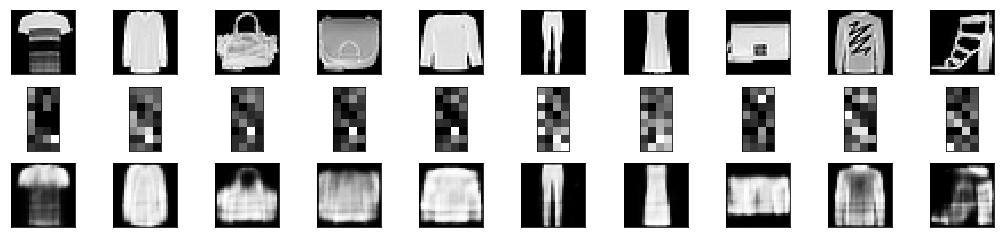

In [22]:
# Randomly Select 10 images from the test set 
num_images = 10
np.random.seed(50)
random_test_images = np.random.randint(x_test.shape[0], size=num_images)

encoded_imgs = encoder.predict(x_test)
decoded_imgs = autoencoder.predict(x_test)

plt.figure(figsize=(18, 4))

for i, image_idx in enumerate(random_test_images):
    # plot original image
    ax = plt.subplot(3, num_images, i + 1)
    plt.imshow(x_test[image_idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # plot encoded image
    ax = plt.subplot(3, num_images, num_images + i + 1)
    plt.imshow(encoded_imgs[image_idx].reshape(8, 4))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # plot reconstructed image
    ax = plt.subplot(3, num_images, 2*num_images + i + 1)
    plt.imshow(decoded_imgs[image_idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

We can see, as expected, the reconstructed images are quite lossy due to the huge reduction in dimensionality. We can see the shapes of these objects clearly, but the loss in image quality has taken away a lot of distinguishing features. So the compression is not highly impressive, but it works , and proves the point. We can improve the peroformance of such AEs using deeper networks as we shall see in our next lab. 


## Summary 

In this lab, we built a simple autoencoder using the fashion-MNIST dataset for a problem of image compression. We looked into creating the encoder and decoder layers in Keras and Training the model. We also visually inspected the results of this compression. 

In [23]:
autoencoder = Sequential()

# Encoder Layers
autoencoder.add(Dense(4 * encoding_dim, input_shape=(input_dim,), activation='relu'))
autoencoder.add(Dense(2 * encoding_dim, activation='relu'))
autoencoder.add(Dense(encoding_dim, activation='relu'))

# Decoder Layers
autoencoder.add(Dense(2 * encoding_dim, activation='relu'))
autoencoder.add(Dense(4 * encoding_dim, activation='relu'))
autoencoder.add(Dense(input_dim, activation='sigmoid'))

autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_6 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_7 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_8 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_9 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_10 (Dense)             (None, 784)               101136    
Total params: 222,384
Trainable params: 222,384
Non-trainable params: 0
_________________________________________________________________


In [24]:
input_img = Input(shape=(input_dim,))
encoder_layer1 = autoencoder.layers[0]
encoder_layer2 = autoencoder.layers[1]
encoder_layer3 = autoencoder.layers[2]
encoder = Model(input_img, encoder_layer3(encoder_layer2(encoder_layer1(input_img))))

encoder.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_6 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_7 (Dense)              (None, 32)                2080      
Total params: 110,816
Trainable params: 110,816
Non-trainable params: 0
_________________________________________________________________


In [25]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 3s 55us/step - loss: 0.3797 - val_loss: 0.3192
Epoch 2/50
60000/60000 [==============================] - 3s 48us/step - loss: 0.3102 - val_loss: 0.3074
Epoch 3/50
60000/60000 [==============================] - 3s 47us/step - loss: 0.3018 - val_loss: 0.3021
Epoch 4/50
60000/60000 [==============================] - 3s 49us/step - loss: 0.2974 - val_loss: 0.2984
Epoch 5/50
60000/60000 [==============================] - 3s 48us/step - loss: 0.2944 - val_loss: 0.2955
Epoch 6/50
60000/60000 [==============================] - 3s 49us/step - loss: 0.2922 - val_loss: 0.2933
Epoch 7/50
60000/60000 [==============================] - 3s 52us/step - loss: 0.2905 - val_loss: 0.2917
Epoch 8/50
60000/60000 [==============================] - 3s 51us/step - loss: 0.2890 - val_loss: 0.2905
Epoch 9/50
60000/60000 [==============================] - 3s 50us/step - loss: 0.2876 - val_loss: 0.2891
Epoch

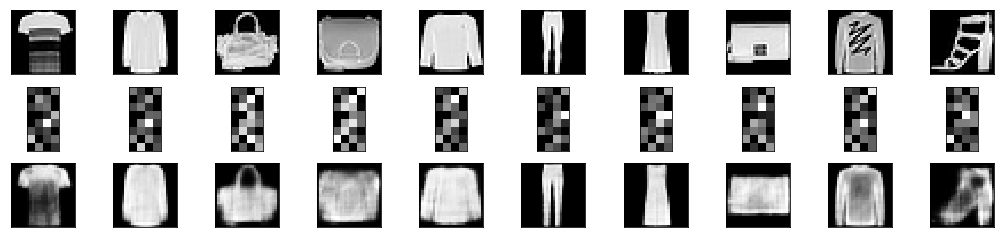

In [26]:
num_images = 10
np.random.seed(42)
random_test_images = np.random.randint(x_test.shape[0], size=num_images)

encoded_imgs = encoder.predict(x_test)
decoded_imgs = autoencoder.predict(x_test)

plt.figure(figsize=(18, 4))

for i, image_idx in enumerate(random_test_images):
    # plot original image
    ax = plt.subplot(3, num_images, i + 1)
    plt.imshow(x_test[image_idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # plot encoded image
    ax = plt.subplot(3, num_images, num_images + i + 1)
    plt.imshow(encoded_imgs[image_idx].reshape(8, 4))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # plot reconstructed image
    ax = plt.subplot(3, num_images, 2*num_images + i + 1)
    plt.imshow(decoded_imgs[image_idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
